# 2. Image classification and denoising

### The CIFAR-10 dataset
In this assignment, we will work on the [**CIFAR-10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto.  This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images. 

			
### Question 1: Data loading and manipulation (4 marks)

1a. **Download** both the training and test data of the CIFAR-10 dataset, e.g., by following the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You can also download via other ways if you prefer.

1b. **Add random noise** to all training and test data to generate noisy dataset, e.g., by `torch.randn()`, with a scaling  factor `scale`, e.g., original image `+ scale * torch.randn()`, and **normalise/standardise** the pixel values to the **original range**, e.g.,  using `np.clip()`. You may choose any `scale` value between 0.2 and 0.5. 

**Note: Before generating the random noise, you MUST set the random seed to your UCard number XXXXXXXXX for reproducibility, e.g., using `torch.manual_seed()`. This seed needs to be used for all remaining code if there is randomness, for reproducibility.**

1c. **Extract a subset** with only two classes: **Cat** and **Dog** and name it starting with **CatDog**.        

1d. Show 10 pairs of original and noisy images of cats and 10 pairs of original and noisy images of dogs.

#### Question 1 Answer

In [1]:
# Write the code for your answer here. You can use multiple cells to improve readability.
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
# 1a.Download both the training and test data of the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 1b. Add random noise to all training and test data
Noisy_trainset = []
Noisy_testset = []
scale = 0.2
torch.manual_seed(1718979)
for images,labels in trainset:
    images = images + scale * torch.randn(3,32,32)
    torch.clamp(images, -1, 1, out=images) #normalise/standardise the pixel values to the original range
    Noisy_trainset.append((images,labels))
for images,labels in testset:
    images = images + scale * torch.randn(3,32,32)
    torch.clamp(images, -1, 1, out=images)
    Noisy_testset.append((images,labels))

In [4]:
# 1c.Extract a subset with only two classes: Cat and Dog and name it starting with CatDog.
CatDog = []
for images,labels in trainset:
    if labels == 3 or labels == 5:
        CatDog.append((images,labels))

CatDog_test = []
for images,labels in testset:
    if labels == 3 or labels == 5:
        CatDog_test.append((images,labels))


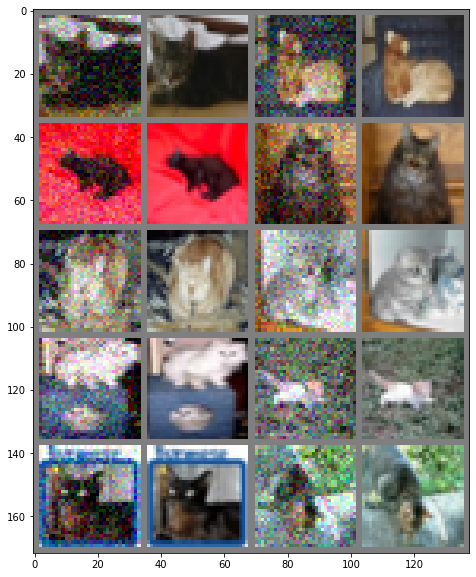

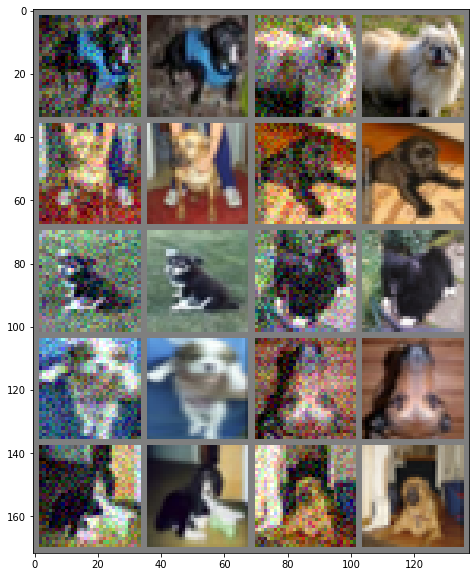

In [7]:
# 1d. Show 10 pairs of original and noisy images of cats and 10 pairs of original and noisy images of dogs.

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

cats_Noisy = []
count = 0
for image,labels in Noisy_trainset:
    if labels == 3:
        cats_Noisy.append(image)
        count += 1
        if count==10:
            break;

cats = []
count = 0
for images,labels in CatDog:
    if labels == 3:
        cats.append(images)
        count += 1
        if count==10:
            break;


# Show 10 pairs of noisy and original images of cats
length = 20
cat_pairs = [0]*length
for i,image in enumerate(cats_Noisy):
    cat_pairs[i*2] = image
for i,image in enumerate(cats):
    cat_pairs[i*2+1] = image    
imshow(torchvision.utils.make_grid(cat_pairs, nrow = 4))    
 
    

dogs_Noisy = []
count = 0
for image,labels in Noisy_trainset:
    if labels == 5:
        dogs_Noisy.append(image)
        count += 1
        if count==10:
            break;

dogs = []
count = 0
for images,labels in CatDog:
    if labels == 5:
        dogs.append(images)
        count += 1
        if count==10:
            break;

# Show 10 pairs of noisy and original images of dogs    
dogs_pairs = [0]*length
for i,image in enumerate(dogs_Noisy):
    dogs_pairs[i*2] = image
for i,image in enumerate(dogs):
    dogs_pairs[i*2+1] = image 
imshow(torchvision.utils.make_grid(dogs_pairs, nrow = 4)) 
    
    

### Question 2: Dimensionality reduction, binary classification, and evaluation (6 marks)

This question uses the **CatDog** subset **with no noise added**.

#### Training

2a. Apply PCA on the training set to reduce the dimensionality. You need to study **at least seven** different values ($k_1, k_2, ..., k_7$) for the reduced dimensionality. **Explain** your choice.

2b. Train **eight** Naive Bayes Classifiers (NBC): one on the original features (raw pixels), and seven on PCA features with seven different dimensions in 2a, i.e., NBC on $k_1$ PCA features; NBC on $k_2$ PCA features; ..., NBC on $k_7$ PCA features. You will need to decide on what Naive Bayes classifier (Gaussian? Multinomial? etc.) to use and **explain** your choice.

#### Testing and evaluation
2c. Evalaute the eight Naive Bayes classifiers on the test set in terms of **classification accuracy** and **visualise** their performance using a bar graph.

2d. Plot the [ROC Curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in true positive rates vs false positive rates for the eight Naive Bayes classifiers in **one figure** using eight different line/marker styles clearly labelled. 

2e. Compute the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) values for the eight Naive Bayes classifiers and visualise using a bar graph.

2f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 


In [8]:
# Write the code for your answer here. You can use multiple cells to improve readability.
# 2a.Apply PCA on the training set to reduce the dimensionality.
x_train = [] #Image data from the CatDog dataset
y_train = [] #Label data from the CatDog dataset
for image,label in CatDog:
    image_np = image.numpy().reshape(3*32*32)
    x_train.append(image_np)
    y_train.append(label)

x_train_mat = np.array(x_train) #Get training set picture matrix
y_train_mat = np.array(y_train) #Get training set picture label matrix

pca = PCA()
pca.fit_transform(x_train_mat)

# Calculating optimal k to have 95% (say) variance 
k = 0
current_sum = 0
total = sum(pca.explained_variance_)
while(current_sum / total < 0.95):
    current_sum += pca.explained_variance_[k]
    k += 1


In [9]:
k

184

In [10]:
# When extracting 95% variance, k is 184, so I take the following seven values( 𝑘1,𝑘2,...,𝑘7 )and record them in k_values
k_values = [20,50,80,110,140,170,200]

In [11]:
# Applying PCA with k_values above,and store to list CatDog_train_pca
x_train_pca = []
for k in k_values:
    pca = PCA(n_components=k, whiten=True)
    x_pca = pca.fit_transform(x_train_mat)
    x_train_pca.append(x_pca)
pca_model = [] #Record PCA Model for different k_values
for i in range(7):
    pca = PCA(n_components = k_values[i],whiten = True).fit(x_train_mat)   
    pca_model.append(pca)

In [12]:
# 2b Train eight Naive Bayes Classifiers (NBC): one on the original features (raw pixels), 
#and seven on PCA features with seven different dimensions in 2a
from sklearn.naive_bayes import GaussianNB

model_original = GaussianNB()
model_original.fit(x_train_mat, y_train_mat)
model_k = []
for i in range(7):
    classifier = GaussianNB()
    classifier.fit(x_train_pca[i], y_train_mat)
    model_k.append(classifier)


The classifier uses Gaussian instead of Multinomial， because Multinomial Classifiers Input X must be non-negative


In [13]:
# 2c Evalaute the eight Naive Bayes classifiers on the test set in terms of classification accuracy
x_test = []
y_test = []
for image,label in CatDog_test:
    image_np = image.numpy().reshape(3*32*32)
    x_test.append(image_np)
    y_test.append(label)

x_test_mat = np.array(x_test) #Get training set picture matrix
y_test_mat = np.array(y_test) #Get training set picture label matrix

In [14]:
# Applying PCA to reduced dimensionality.
x_test_pca = []
for i in range(7):
    x_test_ = pca_model[i].fit_transform(x_test_mat)
    x_test_pca.append(x_test_)

In [18]:
# Classification accuracy of Naive Bayes classifiers of original features 
y_prob = []
y_prob.append(model_original.score(x_test_mat, y_test_mat))
print(y_prob)

[0.5935]


In [19]:
# Classification accuracy of Naive Bayes classifiers of PCA features 
for i in range(7):
    y_prob.append(model_k[i].score(x_test_pca[i], y_test_mat))
print(y_prob)

[0.5935, 0.536, 0.5605, 0.547, 0.546, 0.532, 0.5335, 0.5295]


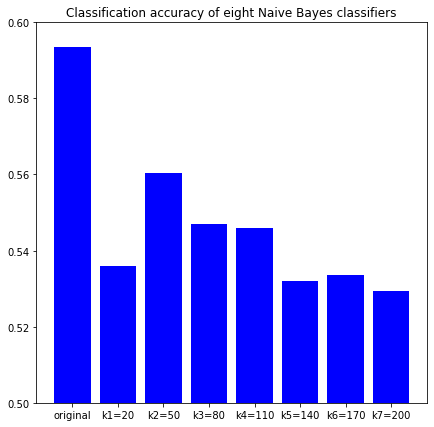

In [20]:
# visualise their performance using a bar graph.
plt.figure(figsize=(7,7))
plt.ylim(0.5,0.6)
name_list = ['original','k1=20','k2=50','k3=80','k4=110','k5=140','k6=170','k7=200']
num_list = y_prob
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title("Classification accuracy of eight Naive Bayes classifiers")
plt.show()


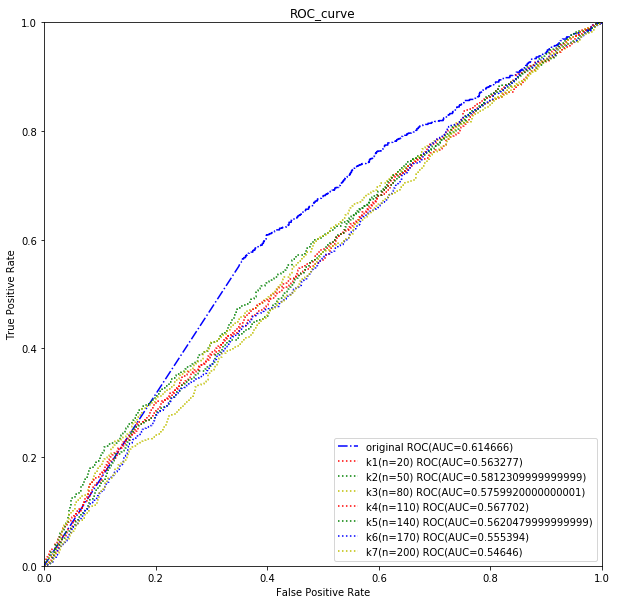

In [22]:
# 2d Plot the ROC Curves in true positive rates vs false positive rates
from sklearn.metrics import roc_curve  
from sklearn.metrics import auc 

y_original_pre = model_original.predict_proba(x_test_mat)
y_pre = []
for i in range(7):
    y_pre.append(model_k[i].predict_proba(x_test_pca[i]))

AUC_list = []    
fpr, tpr, thresholds = roc_curve(y_test_mat, y_original_pre[:,1], pos_label=5) 
AUC = auc(fpr, tpr) 
AUC_list.append(AUC)
fpr1, tpr1, thresholds1 = roc_curve(y_test_mat, y_pre[0][:,1], pos_label=5) 
AUC1 = auc(fpr1, tpr1) 
AUC_list.append(AUC1)
fpr2, tpr2, thresholds2 = roc_curve(y_test_mat, y_pre[1][:,1], pos_label=5) 
AUC2 = auc(fpr2, tpr2)
AUC_list.append(AUC2)
fpr3, tpr3, thresholds3 = roc_curve(y_test_mat, y_pre[2][:,1], pos_label=5) 
AUC3 = auc(fpr3, tpr3)
AUC_list.append(AUC3)
fpr4, tpr4, thresholds4 = roc_curve(y_test_mat, y_pre[3][:,1], pos_label=5) 
AUC4 = auc(fpr4, tpr4)
AUC_list.append(AUC4)
fpr5, tpr5, thresholds5 = roc_curve(y_test_mat, y_pre[4][:,1], pos_label=5) 
AUC5 = auc(fpr5, tpr5)
AUC_list.append(AUC5)
fpr6, tpr6, thresholds6 = roc_curve(y_test_mat, y_pre[5][:,1], pos_label=5) 
AUC6 = auc(fpr6, tpr6) 
AUC_list.append(AUC6)
fpr7, tpr7, thresholds7 = roc_curve(y_test_mat, y_pre[6][:,1], pos_label=5) 
AUC7 = auc(fpr7, tpr7)
AUC_list.append(AUC7)


plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,linestyle='-.',color='b',label = 'original ROC'+ '(AUC='+str(AUC)+')')  
plt.plot(fpr1,tpr1,linestyle=':',color='r',label = 'k1(n=20) ROC'+ '(AUC='+str(AUC1)+')')
plt.plot(fpr2,tpr2,linestyle=':',color='g',label = 'k2(n=50) ROC'+ '(AUC='+str(AUC2)+')')
plt.plot(fpr3,tpr3,linestyle=':',color='y',label = 'k3(n=80) ROC'+ '(AUC='+str(AUC3)+')')
plt.plot(fpr4,tpr4,linestyle=':',color='r',label = 'k4(n=110) ROC'+ '(AUC='+str(AUC4)+')')  
plt.plot(fpr5,tpr5,linestyle=':',color='g',label = 'k5(n=140) ROC'+ '(AUC='+str(AUC5)+')')
plt.plot(fpr6,tpr6,linestyle=':',color='b',label = 'k6(n=170) ROC'+ '(AUC='+str(AUC6)+')')
plt.plot(fpr7,tpr7,linestyle=':',color='y',label = 'k7(n=200) ROC'+ '(AUC='+str(AUC7)+')')  



plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC_curve' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.legend(loc = "lower right")
plt.show() 



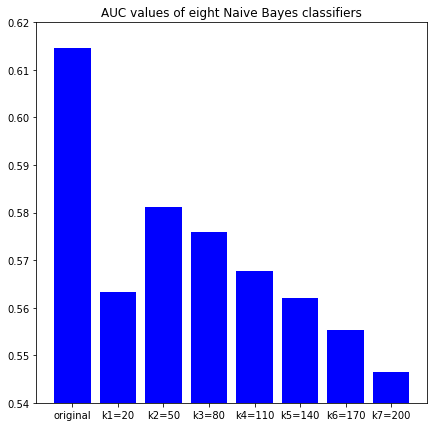

In [24]:
# 2e. Compute the area under the ROC curve values for the eight Naive Bayes classifiers and visualise using a bar graph.

# The area under the ROC curve values for the eight Naive Bayes classifiers stored in AUC_list
plt.figure(figsize=(7,7))
plt.ylim(0.54,0.62)
name_list = ['original','k1=20','k2=50','k3=80','k4=110','k5=140','k6=170','k7=200']
num_list = AUC_list
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title('AUC values of eight Naive Bayes classifiers' )
plt.show()


Answr 2f
1. The classifier without reducing dimensionality(original dimensionality) has the highest accuracy. Besides, with respect to seven different values ( 𝑘1,𝑘2,...,𝑘7 ) for the reduced dimensionality，the model has the highest accuracy when K=50, so I guess that the model with K in the 50-80 range performs best.
2. The ROC curve can be used to compare the relative performance of different classifiers. 
3. The value of AUC is positively related to the performance of the classifier. In other words, the greater the accuracy of the classifier, the greater the value of AUC.

### Question 3: Noisy data and multiclass classification (6 marks)

#### Noisy **CatDog** subset.

3a. Repeat 2a, 2b, and 2c on the noisy version of CatDog subset. Show the bar graph and compare it with that in 2c above. 

#### Multiclass classification using the original CIFAR-10 dataset (all 10 classes)

3b. Apply PCA on the training set to reduce the dimensionality. You need to study at least **three** different values for the reduced dimensionality. Explain your choice.

3c. Train nine classifers: **four Naive Bayes** classifiers(one on the original features, and three on PCA features with three different dimensions in 3b); **four Logistic Regression** classifiers (one on the original features, and three on PCA features with three different dimensions in 3b); and one **Convoluational Neural Network** as defined in the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

3d. Evalaute the nine classifiers on the test set. Summarise the **classification accuracy**, **total training time**, and **total test time** using three bar graphs.

3e. Show the confusion matrix for these nine classifiers (see Lab 8 - 1.4).

3f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

In [25]:
# Write the code for your answer here. You can use multiple cells to improve readability.
# 3a. Repeat 2a, 2b, and 2c on the noisy version of CatDog subset.
CatDog_noisy = []
for images,labels in Noisy_trainset:
    if labels == 3 or labels == 5:
        CatDog_noisy.append((images,labels))

CatDog_test_noisy = []
for images,labels in Noisy_testset:
    if labels == 3 or labels == 5:
        CatDog_test_noisy.append((images,labels))

In [26]:
x_train_noisy = []
y_train_noisy = []
for image,label in CatDog_noisy:
    image_np = image.numpy().reshape(3*32*32)
    x_train_noisy.append(image_np)
    y_train_noisy.append(label)

x_train_mat_noisy = np.array(x_train_noisy) #Get training set picture matrix
y_train_mat_noisy = np.array(y_train_noisy) #Get training set picture label matrix

In [27]:
# Applying PCA with k_values above,and store to list CatDog_train_pca
x_train_pca = []
for k in k_values:
    pca = PCA(n_components=k, whiten=True)
    x_pca = pca.fit_transform(x_train_mat_noisy)
    x_train_pca.append(x_pca)
pca_model = []
for i in range(7):
    pca = PCA(n_components = k_values[i],whiten = True).fit(x_train_mat_noisy)   
    pca_model.append(pca)

In [28]:
# 2b Train eight Naive Bayes Classifiers (NBC): one on the original features (raw pixels), 
#and seven on PCA features with seven different dimensions in 2a
# The classifier uses Gaussian instead of Multinomial， because Multinomial Classifiers Input X must be non-negative
from sklearn.naive_bayes import GaussianNB

model_original = GaussianNB()
model_original.fit(x_train_mat_noisy, y_train_mat_noisy)
model_k = []
for i in range(7):
    classifier = GaussianNB()
    classifier.fit(x_train_pca[i], y_train_mat_noisy)
    model_k.append(classifier)

In [29]:
# 2c Evalaute the eight Naive Bayes classifiers on the test set in terms of classification accuracy
x_test_noisy = []
y_test_noisy = []
for image,label in CatDog_test_noisy:
    image_np = image.numpy().reshape(3*32*32)
    x_test_noisy.append(image_np)
    y_test_noisy.append(label)

x_test_mat_noisy = np.array(x_test_noisy) #Get training set picture matrix
y_test_mat_noisy = np.array(y_test_noisy) #Get training set picture label matrix

In [30]:
# Applying PCA to reduced dimensionality.
x_test_pca = []
for i in range(7):
    x_test_ = pca_model[i].fit_transform(x_test_mat_noisy)
    x_test_pca.append(x_test_)

In [32]:
y_prob = []
y_prob.append(model_original.score(x_test_mat_noisy, y_test_mat_noisy))
for i in range(7):
    y_prob.append(model_k[i].score(x_test_pca[i], y_test_mat_noisy))
print(y_prob)

[0.5875, 0.5415, 0.5555, 0.546, 0.5455, 0.541, 0.536, 0.536]


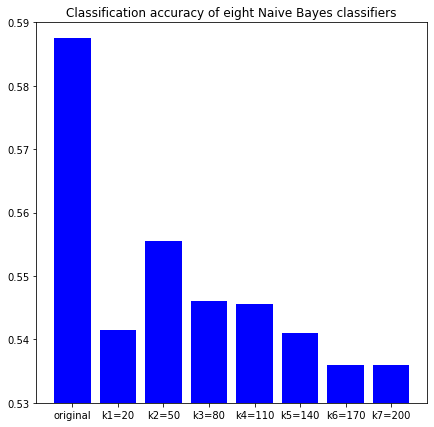

In [34]:
# visualise their performance using a bar graph.
plt.figure(figsize=(7,7))
plt.ylim(0.53,0.59)
name_list = ['original','k1=20','k2=50','k3=80','k4=110','k5=140','k6=170','k7=200']
num_list = y_prob
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title("Classification accuracy of eight Naive Bayes classifiers")
plt.show()

In [35]:
# 3b. Apply PCA on the training set to reduce the dimensionality. You need to study at least three different values for the reduced dimensionality. 
x_all_train = []
y_all_train = []
for image,label in trainset:
    image_np = image.numpy().reshape(3*32*32)
    x_all_train.append(image_np)
    y_all_train.append(label)

x_all_train_mat = np.array(x_all_train) #Get training set picture matrix
y_all_train_mat = np.array(y_all_train) #Get training set picture label matrix



In [36]:
pca = PCA()
pca.fit_transform(x_all_train_mat)

# Calculating optimal k to have 95% (say) variance 
k = 0
current_sum = 0
total = sum(pca.explained_variance_)
while(current_sum / total < 0.95):
    current_sum += pca.explained_variance_[k]
    k += 1
print(k)

217


In [38]:
# When extracting 95% variance, k is 217, so I take the following three values( 𝑘1,𝑘2,𝑘3 )and record them in k_values
k_all_values = [50,100,200]

In [39]:
x_all_train_pca = []
for k in k_all_values:
    pca = PCA(n_components=k, whiten=True)
    x_pca = pca.fit_transform(x_all_train_mat)
    x_all_train_pca.append(x_pca)
pca_all_model = []
for i in range(3):
    pca = PCA(n_components = k_all_values[i],whiten = True).fit(x_all_train_mat)   
    pca_all_model.append(pca)

In [40]:
# 3c. Train nine classifers: 
#four Naive Bayes classifiers(one on the original features, and three on PCA features with three different dimensions in 3b); 
#four Logistic Regression classifiers (one on the original features, and three on PCA features with three different dimensions in 3b); 
#and one Convoluational Neural Network as defined in the pytorch CIFAR10 tutorial.
from time import time
from sklearn.naive_bayes import GaussianNB
timelist = []
#four Naive Bayes classifiers
model_Gauss = []
start_time = time()
model_original = GaussianNB()
model_original.fit(x_all_train_mat, y_all_train_mat)
end_time = time()
timelist.append(end_time-start_time)
model_Gauss.append(model_original)
for i in range(3):
    start_time = time()
    classifier = GaussianNB()
    classifier.fit(x_all_train_pca[i], y_all_train_mat)
    end_time = time()
    timelist.append(end_time-start_time)
    model_Gauss.append(classifier)



In [10]:
#four Logistic Regression classifiers
from sklearn.linear_model import LogisticRegression 
model_LR = []
start_time = time()
model_LR_original = LogisticRegression(solver='liblinear')
model_LR_original.fit(x_all_train_mat, y_all_train_mat)  
end_time = time()
timelist.append(end_time-start_time)
model_LR.append(model_LR_original)
for i in range(3):
    start_time = time()
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(x_all_train_pca[i], y_all_train_mat)
    end_time = time()
    timelist.append(end_time-start_time)
    model_LR.append(classifier)


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [43]:
#One Convoluational Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

start_time = time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')
end_time = time()
timelist.append(end_time-start_time)


[1,  2000] loss: 2.234
[1,  4000] loss: 1.900
[1,  6000] loss: 1.672
[1,  8000] loss: 1.567
[1, 10000] loss: 1.530
[1, 12000] loss: 1.473
[2,  2000] loss: 1.395
[2,  4000] loss: 1.397
[2,  6000] loss: 1.345
[2,  8000] loss: 1.346
[2, 10000] loss: 1.282
[2, 12000] loss: 1.280
Finished Training


In [44]:
# 3d. Evalaute the nine classifiers on the test set. 
#Summarise the classification accuracy, total training time, and total test time using three bar graphs.
x_all_test = []
y_all_test = []
for image,label in testset:
    image_np = image.numpy().reshape(3*32*32)
    x_all_test.append(image_np)
    y_all_test.append(label)

x_all_test_mat = np.array(x_all_test) #Get testing set picture matrix
y_all_test_mat= np.array(y_all_test) #Get testing set picture label matrix


In [45]:
timelist_test = []
test_prob = []# accuracy for test
# Naive Bayes classifiers on testset
start_time = time()
test_prob.append(model_Gauss[0].score(x_all_test_mat,y_all_test_mat))
end_time = time()
timelist_test.append(end_time-start_time)
for i in range(3):
    start_time = time()
    test_prob.append(model_Gauss[i+1].score(pca_all_model[i].transform(x_all_test_mat),y_all_test_mat))
    end_time = time()
    timelist_test.append(end_time-start_time)



In [15]:
# Logistic Regression classifiers on testset
start_time = time()
test_prob.append(model_LR[0].score(x_all_test_mat,y_all_test_mat))
end_time = time()
timelist_test.append(end_time-start_time)
for i in range(3):
    start_time = time()
    test_prob.append(model_LR[i+1].score(pca_all_model[i].transform(x_all_test_mat),y_all_test_mat))
    end_time = time()
    timelist_test.append(end_time-start_time)


In [46]:
# Convoluational Neural Network on testset
correct = 0
total = 0
cnn_predict = []
start_time = time()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for label in predicted:
            cnn_predict.append(label.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
end_time = time()
timelist_test.append(end_time-start_time)
test_prob.append(correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [49]:
print(test_prob)
print(timelist)
print(timelist_test)

[0.2976, 0.3469, 0.3361, 0.3118, 0.3798, 0.377, 0.4013, 0.4013, 0.5392]
[1.7453234195709229, 0.03092360496520996, 0.05984187126159668, 0.11568260192871094, 3975.962275981903, 3.6443653106689453, 5.106302499771118, 8.363034009933472, 204.24325847625732]
[4.304458379745483, 0.2124314308166504, 0.292219877243042, 0.4508202075958252, 0.21429753303527832, 0.16256499290466309, 0.18350982666015625, 0.21342897415161133, 5.397885322570801]


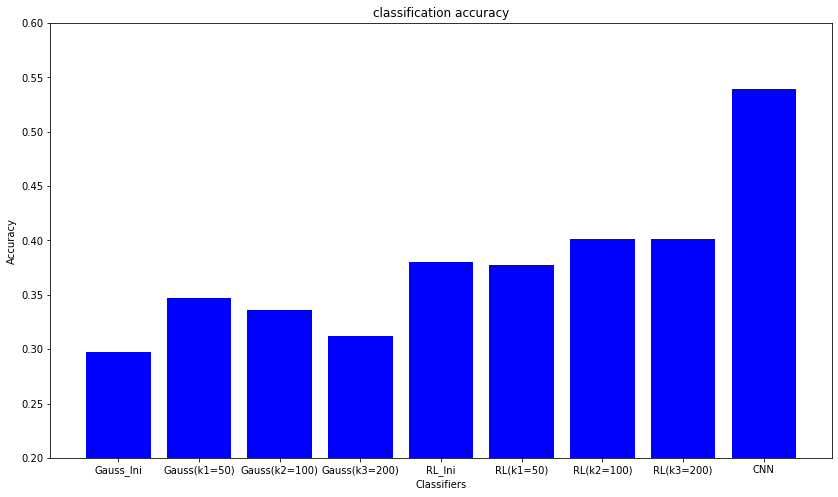

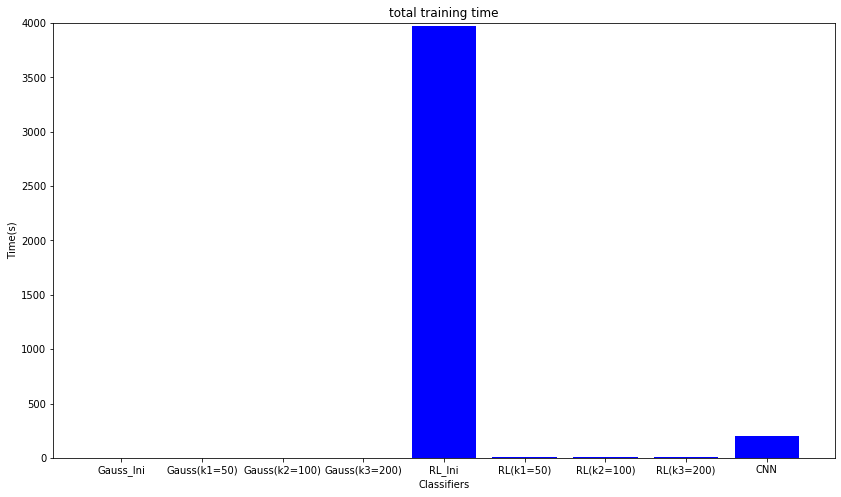

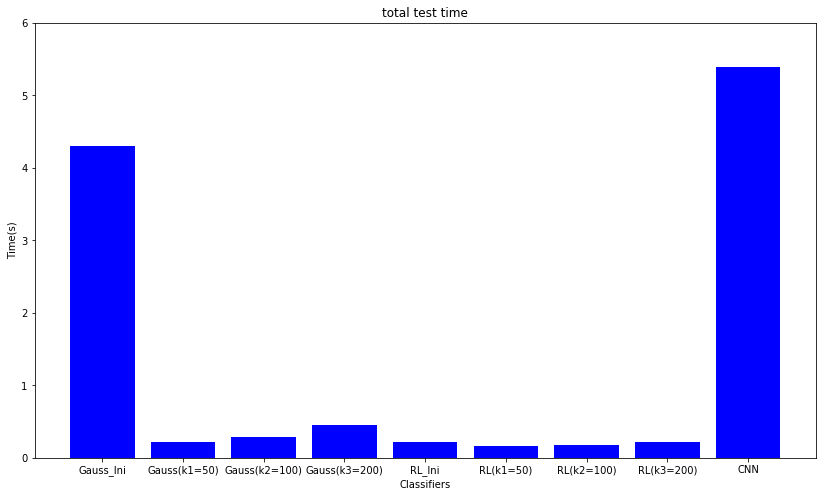

In [50]:
# Summarise the classification accuracy, total training time, and total test time using three bar graphs.
plt.figure(figsize=(14,8))
plt.ylim(0.2,0.6)
name_list = ['Gauss_Ini','Gauss(k1=50)','Gauss(k2=100)','Gauss(k3=200)','RL_Ini','RL(k1=50)','RL(k2=100)','RL(k3=200)','CNN']
num_list = test_prob
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title('classification accuracy' )
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(14,8))
plt.ylim(0,4000)
name_list = ['Gauss_Ini','Gauss(k1=50)','Gauss(k2=100)','Gauss(k3=200)','RL_Ini','RL(k1=50)','RL(k2=100)','RL(k3=200)','CNN']
num_list = timelist
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title('total training time' )
plt.xlabel('Classifiers')
plt.ylabel('Time(s)')
plt.show()

plt.figure(figsize=(14,8))
plt.ylim(0,6)
name_list = ['Gauss_Ini','Gauss(k1=50)','Gauss(k2=100)','Gauss(k3=200)','RL_Ini','RL(k1=50)','RL(k2=100)','RL(k3=200)','CNN']
num_list = timelist_test
plt.bar(range(len(num_list)),num_list,color='b',tick_label=name_list)
plt.title('total test time' )
plt.xlabel('Classifiers')
plt.ylabel('Time(s)')
plt.show()

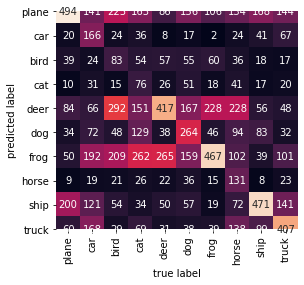

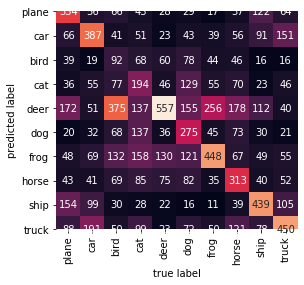

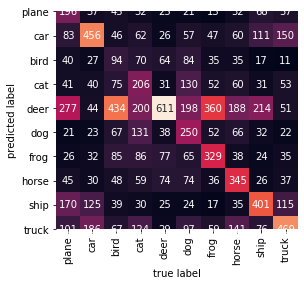

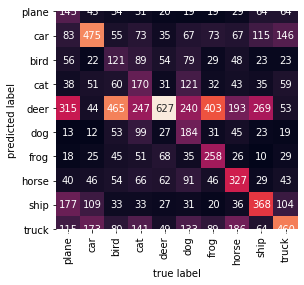

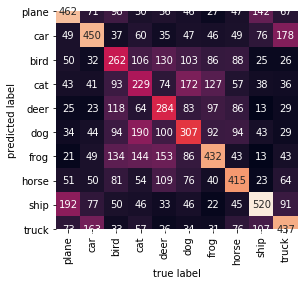

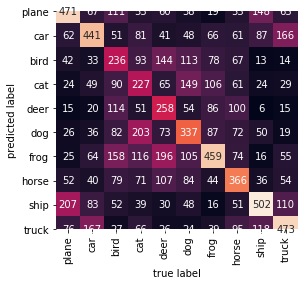

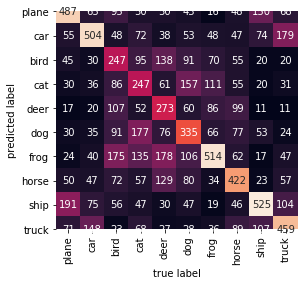

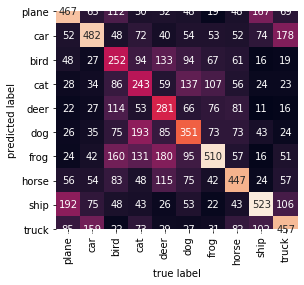

In [67]:
# 3e. Show the confusion matrix for these nine classifiers
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Show the confusion matrix for Naive Bayes classifier(4)
mat = confusion_matrix(y_all_test_mat, model_Gauss[0].predict(x_all_test_mat))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

for i in range(3):
    mat = confusion_matrix(y_all_test_mat, model_Gauss[i+1].predict(pca_all_model[i].transform(x_all_test_mat)))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

#Show the confusion matrix for Logistic Regression classifier(4)
mat = confusion_matrix(y_all_test_mat, model_LR[0].predict(x_all_test_mat))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

for i in range(3):
    mat = confusion_matrix(y_all_test_mat, model_LR[i+1].predict(pca_all_model[i].transform(x_all_test_mat)))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()


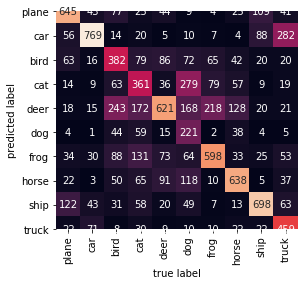

In [53]:
#Show the confusion matrix for CNN classifier
mat = confusion_matrix(y_all_test_mat, cnn_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Answer 3f
1. Overall, for the three category classifiers, the accuracy of Convoluational Neural Network is higher than Logistic Regression classifiers and Naive Bayes classifiers，and the accuracy of Logistic Regression classifiers is higher than Naive Bayes classifiers.
2. For Logistic Regression classifiers and Naive Bayes classifiers, the accuracy of their classifier without reducing dimensionality is not the highest, and the classifier model training using PCA features after dimensionality reduction has a higher recognition rate, such as, for the case of Naive Bayes classifier K = 50 and Logistic Regression classifier K = 100.
3. For the training process of the classifier model, the time of Naive Bayes classifier is the shortest, and CNN is the second，while  for the case of the Logistic Regression classifier does not use the dimensionality reduction data feature, the model training time is very long, which takes tens of minutes.The test process for the classifier model is different，the test time of the Logistic Regression classifier is very short, but for the Naive Bayes classifier does not use the dimensionality reduction data feature, it takes a relatively long time to test.

### Question 4: Denoising Autoencoder (4 marks)

This question uses both the original and noisy CIFAR-10 datasets (all 10 classes).

Read about denoising autoencoder at [Wikepedia](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) and this [short introduction](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2) or any other sources you like.

4a. Modify the autoencoder architecture in Lab 7 so that it takes colour images as input (i.e., 3 input channels). 

4b. **Training**: feed the **noisy training images** as input to the autoencoder in 4a; use a loss function that computes the reconstruction error between the **output of the autoencoder** and the respective **original images**.

4c. **Testing**: evaluate the autoencoder trained in 4b on the test datasets (feed noisy images in and compute reconstruction errors on original clean images. Find the **worstly denoised** 30 images (those with the largest reconstruction errors) in the test set and show them in pairs with the original images (60 images to show in total).

4d. Choose at least two hyperparameters to vary. Study **at least three different choices** for each hyperparameter. When varying one hyperparameter, all the other hyperparameters can be fixed. Visualise the performance sensitivity with respect to these hyperparameters.

4e. Describe **at least two** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

In [14]:
# Write the code for your answer here. You can use multiple cells to improve readability.

In [15]:
#4a. Modify the autoencoder architecture in Lab 7 so that it takes colour images as input (i.e., 3 input channels).
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 3 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
# 4b. Training: feed the noisy training images as input to the autoencoder in 4a; 
#use a loss function that computes the reconstruction error between the output of the autoencoder and the respective original images.
myAE=Autoencoder()
#Hyperparameters for training
batch_size = 64
learning_rate=0.001
max_epochs = 20


criterion = nn.MSELoss() 

optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loader_Noisy = torch.utils.data.DataLoader(Noisy_trainset,batch_size=batch_size, shuffle=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=False)

outputs = []

#Start training
for epoch in range(max_epochs):
    for data_Noisy,data in zip(train_loader_Noisy,train_loader):
        img_Noisy, label_Noisy = data_Noisy
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img_Noisy)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 3) == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)


Epoch:1, Loss:0.1032
Epoch:4, Loss:0.0927
Epoch:7, Loss:0.0912
Epoch:10, Loss:0.0906
Epoch:13, Loss:0.0902
Epoch:16, Loss:0.0899
Epoch:19, Loss:0.0898


In [48]:
# 4c. Testing: evaluate the autoencoder trained in 4b on the test datasets 
#feed noisy images in and compute reconstruction errors on original clean images. 

test_loader_Noisy = torch.utils.data.DataLoader(Noisy_testset,batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=False)
test_loss = [] # Record loss,output of the autoencoder(noisy images as input), original images.
for data_Noisy,data in zip(test_loader_Noisy,test_loader):
    img_Noisy, label_Noisy = data_Noisy
    img, label = data
    recon = myAE(img_Noisy)
    loss = criterion(recon,img)
    test_loss.append((loss,recon,img))


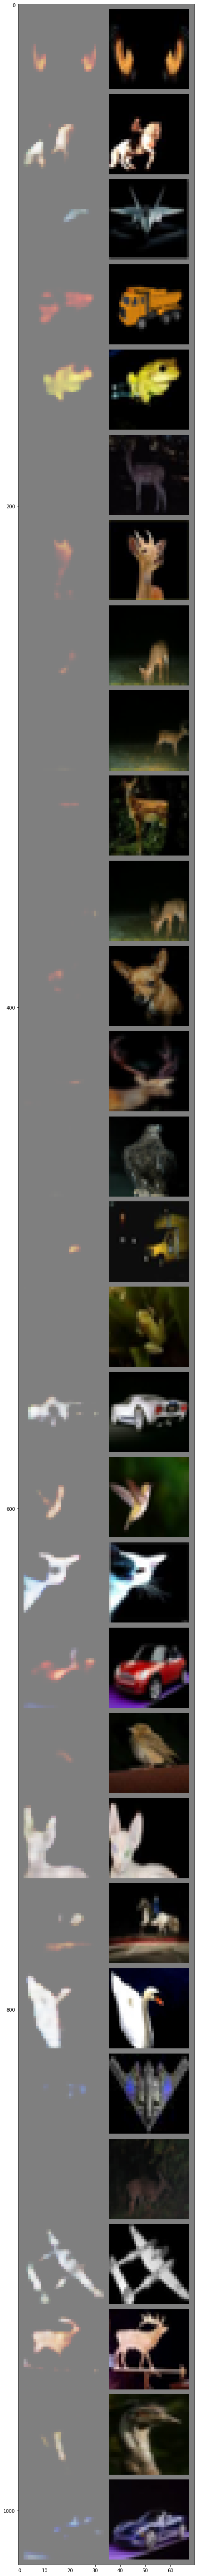

In [82]:
#Find the worstly denoised 30 images in the test set and show them in pairs with the original images 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.figure(figsize=(100,100))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

test_loss_new = sorted(test_loss, key=lambda x: x[0], reverse=True)
test_loss_new = test_loss_new[:30]
image_list = []
for data in test_loss_new:
    loss,recon,img = data
    image_list.append(recon.view(3,32,32))
    image_list.append(img.view(3,32,32))

imshow(torchvision.utils.make_grid(image_list, nrow = 2))
    



In [ ]:
#4d. Choose at least two hyperparameters to vary. Study at least three different choices for each hyperparameter. 

#Hyperparameters for training
#Choose two hyperparameters to vary: batch_size and learning_rate
batch_size = [16,32,64]
learning_rate = [0.01,0.001,0.0001]
max_epochs = 20


loss_list = [] # Store the loss of nine different combinations of hyperparameter training models

#Start training
for i,batch_s in enumerate(batch_size):
    for j,learning_r in enumerate(learning_rate):
        myAE=Autoencoder()
        criterion = nn.MSELoss() 
        optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_r, weight_decay=1e-5)
        train_loader_Noisy = torch.utils.data.DataLoader(Noisy_trainset,batch_size=batch_s, shuffle=False)
        train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_s, shuffle=False)      
        for epoch in range(max_epochs):
            for data_Noisy,data in zip(train_loader_Noisy,train_loader):
                img_Noisy, label_Noisy = data_Noisy
                img, label = data
                optimizer.zero_grad()
                recon = myAE(img_Noisy)
                loss = criterion(recon, img)
                loss.backward()
                optimizer.step()            
        loss_list.append(loss)
        


Answer 4e
1. The Autoencoder is able to reconstruct corrupted data，during the process of training model, we found that the loss between the reconstructed data (output) of the Autoencoder and the original image is constantly converging when we input the noisy image to the Autoencoder.
2. From the 4c test, we can see that the model tested the 30 pictures pair with the largest loss between the reconstruct image and the original image. We can also see from the returned image pair that the difference between the reconstructed image and the original image is very large, and even our eyes cannot match it.